### Distilling the Knowledge in a Neural Network

https://arxiv.org/pdf/1503.02531.pdf

In [2]:
from importlib import reload
import models
reload(models)
from __future__ import print_function
import keras
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import numpy as np
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


In [3]:
batch_size = 1000
num_classes = 10
epochs = 60

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                            )

test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
#test_datagen.fit(x_test)

In [5]:
model = dict()
hist = dict()
score = dict()
preds = dict()

In [6]:
reload(models)
model['teacher'] = models.TeacherModel(input_shape, num_classes)

model['teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['teacher'].summary()

W0930 20:05:20.835141 140488202495808 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 20:05:20.872389 140488202495808 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 20:05:20.880152 140488202495808 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 20:05:20.951750 140488202495808 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
__________

In [11]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.teacher.hdf5', 
                               verbose=1, save_best_only=True)

hist['teacher'] = model['teacher'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=100, verbose=1, 
#                                                            validation_data=test_datagen.flow(x_test, y_test), 
#                                                            validation_steps=len(x_train) // batch_size,
                                                           validation_data=(x_test, y_test),
                                                           callbacks=[checkpointer])
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][1])

W0930 14:14:53.959012 140318191400768 deprecation.py:323] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
60/60 [==============================] - 27s 447ms/step - loss: 0.5800 - acc: 0.8056 - val_loss: 0.0629 - val_acc: 0.9779

Epoch 00001: val_loss improved from inf to 0.06294, saving model to saved_models/weights.best.teacher.hdf5
Epoch 2/100
60/60 [==============================] - 22s 366ms/step - loss: 0.1244 - acc: 0.9618 - val_loss: 0.0320 - val_acc: 0.9894

Epoch 00002: val_loss improved from 0.06294 to 0.03200, saving model to saved_models/weights.best.teacher.hdf5
Epoch 3/100
60/60 [==============================] - 23s 388ms/step - loss: 0.0915 - acc: 0.9720 - val_loss: 0.0289 - val_acc: 0.9903

Epoch 00003: val_loss improved from 0.03200 to 0.02891, saving model to saved_models/weights.best.teacher.hdf5
Epoch 4/100
60/60 [==============================] - 23s 381ms/step - loss: 0.0729 - acc: 0.9783 - val_loss: 0.0277 - val_acc: 0.9903

Epoch 00004: val_loss improved from 0.02891 to 0.02767, saving model to saved_models/weights.best.teacher.hdf5
Epoch 5/100
60/60 [=

KeyboardInterrupt: 

In [9]:
model['teacher'].load_weights('saved_models/weights.best.teacher.hdf5')
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['teacher'][-1])*len(y_test))
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.014066617570716061
Test accuracy: 0.9954
Test errors: 46


In [136]:
reload(models)
model['soft_teacher'] = models.SoftTeacherModel(input_shape, num_classes, l1=0.1, l2=0.07, b=4)

model['soft_teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['soft_teacher'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              18875392  
__________

In [137]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.soft_teacher.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_acc')

model['soft_teacher'].load_weights('saved_models/weights.best.soft_teacher.hdf5')
hist['soft_teacher'] = model['soft_teacher'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=30, verbose=1, 
#                                                            validation_data=test_datagen.flow(x_test, y_test), 
#                                                            validation_steps=len(x_train) // batch_size,
                                                           validation_data=(x_test, y_test),
                                                           callbacks=[checkpointer])
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][1])

Epoch 1/30
60/60 [==============================] - 25s 423ms/step - loss: 1.0397 - acc: 0.9913 - val_loss: 1.0202 - val_acc: 0.9945
Epoch 2/30
60/60 [==============================] - 20s 339ms/step - loss: 1.0357 - acc: 0.9920 - val_loss: 1.0179 - val_acc: 0.9951
Epoch 3/30
60/60 [==============================] - 24s 403ms/step - loss: 1.0335 - acc: 0.9922 - val_loss: 1.0176 - val_acc: 0.9942
Epoch 4/30
60/60 [==============================] - 30s 492ms/step - loss: 1.0321 - acc: 0.9919 - val_loss: 1.0160 - val_acc: 0.9936
Epoch 5/30
60/60 [==============================] - 31s 520ms/step - loss: 1.0315 - acc: 0.9919 - val_loss: 1.0165 - val_acc: 0.9939
Epoch 6/30
60/60 [==============================] - 32s 534ms/step - loss: 1.0296 - acc: 0.9928 - val_loss: 1.0147 - val_acc: 0.9939
Epoch 7/30
60/60 [==============================] - 38s 640ms/step - loss: 1.0292 - acc: 0.9931 - val_loss: 1.0172 - val_acc: 0.9936
Epoch 8/30
60/60 [==============================] - 38s 638ms/step - 

KeyboardInterrupt: 

In [141]:
model['soft_teacher'].load_weights('saved_models/weights.best.soft_teacher.hdf5')
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['soft_teacher'][-1])*len(y_test))
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.8385954130172729
Test accuracy: 0.9952
Test errors: 48


In [10]:
reload(models)
model['student'] = models.StudentModel(input_shape, num_classes)

model['student'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['student'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_8 (Dense)              (None, 800)               640800    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                8010      
_________________________________________________________________
o2 (Activation)              (None, 10)                0         
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________


In [116]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_acc')

hist['student'] = model['student'].fit(x_train, y_train, batch_size=batch_size,
          epochs=100, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 99us/step - loss: 0.3994 - acc: 0.8890 - val_loss: 0.1743 - val_acc: 0.9483
Epoch 2/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.1314 - acc: 0.9612 - val_loss: 0.1046 - val_acc: 0.9671
Epoch 3/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0840 - acc: 0.9754 - val_loss: 0.0836 - val_acc: 0.9731
Epoch 4/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0567 - acc: 0.9833 - val_loss: 0.0716 - val_acc: 0.9778
Epoch 5/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0409 - acc: 0.9882 - val_loss: 0.0695 - val_acc: 0.9775
Epoch 6/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0293 - acc: 0.9913 - val_loss: 0.0653 - val_acc: 0.9784
Epoch 7/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0210 - acc: 0.9944 - val_loss: 0.0598 - 

In [11]:
model['student'].load_weights('saved_models/weights.best.student.hdf5')
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student'][-1])*len(y_test))
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][-1])
print('Test errors:', n_errors)

Test loss: 0.074012807541752
Test accuracy: 0.984
Test errors: 160


# Knowledge Distilation

In [142]:
kd_gt = dict()
T = 20
kd_gt['t_train'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['t_test'] = model['teacher'].T_model(T).predict(x_test, verbose=1, batch_size=batch_size)
kd_gt['st_train'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['st_test'] = model['soft_teacher'].predict(x_test, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(kd_gt['t_train'], axis=-1).mean(), np.linalg.norm(kd_gt['st_train'], axis=-1).mean()

10000/10000 [==============================] - 1s 55us/step


(0.3622794, 0.53431916)

In [120]:
# import numpy as np
# from keras.activations import softmax

# def softmax_with_temp(x):
#     Temp = 1.0
#     e_x = np.exp((x - x.max(axis=1, keepdims=True))/Temp)
#     out = e_x / e_x.sum(axis=1, keepdims=True)
#     return out

# def soft_with_T(T=1):
#     def swt(x):
#         return softmax(x/T)
#     return swt

In [82]:
''' KNOWLEDGE DISTILLATION WITH REGULAR TEACHER (TEMPERATURE SOFTMAX) '''
reload(models)
model['student_'] = models.StudentModel(input_shape, num_classes, T=T, in_class=True)
model['student_'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[1., 1. / (T**2)],
                          optimizer='Adam',
                          metrics=['acc'])

In [83]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_loss')

hist['student_'] = model['student_'].fit(x_train, [kd_gt['t_train'], y_train],
          batch_size=batch_size, epochs=100, verbose=1,
          validation_data=(x_test, [kd_gt['t_test'], y_test]), callbacks=[checkpointer])
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 2.2243 - o1_loss: 2.2225 - o2_loss: 0.6856 - o1_acc: 0.8270 - o2_acc: 0.8269 - val_loss: 2.1998 - val_o1_loss: 2.1989 - val_o2_loss: 0.3483 - val_o1_acc: 0.9288 - val_o2_acc: 0.9280
Epoch 2/100
60000/60000 [==============================] - 1s 19us/step - loss: 2.1956 - o1_loss: 2.1949 - o2_loss: 0.2572 - o1_acc: 0.9435 - o2_acc: 0.9433 - val_loss: 2.1925 - val_o1_loss: 2.1920 - val_o2_loss: 0.1918 - val_o1_acc: 0.9580 - val_o2_acc: 0.9575
Epoch 3/100
60000/60000 [==============================] - 1s 18us/step - loss: 2.1907 - o1_loss: 2.1903 - o2_loss: 0.1602 - o1_acc: 0.9640 - o2_acc: 0.9636 - val_loss: 2.1895 - val_o1_loss: 2.1892 - val_o2_loss: 0.1370 - val_o1_acc: 0.9693 - val_o2_acc: 0.9686
Epoch 4/100
60000/60000 [==============================] - 1s 18us/step - loss: 2.1883 - o1_loss: 2.1880 - o2_loss: 0.1138 - o1_acc: 0.9735 - o2_acc: 0.9732 - val_l

In [85]:
model['student_'].load_weights('saved_models/weights.best.student_.hdf5')
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_'][-1])*len(y_test))
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])
print('Test errors:', n_errors)

Test loss: 2.184079764175415
Test accuracy: 0.991
Test errors: 90


In [153]:
''' SOFT TEACHER IN CLASS '''
reload(models)
from keras import callbacks

base_lr = 3e-3
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_st'] = models.StudentModel(input_shape, num_classes, T=1, in_class=True, l2=0, b=0)
model['student_st'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[0.05, 1],
                          optimizer='Adam',
                          metrics=['acc'])

In [154]:
def schedule(epoch):
    return base_lr * decay**(epoch)

#es = callbacks.EarlyStopping(monitor='val_o2_loss', mode='min', verbose=0, patience=30)
#mc = callbacks.ModelCheckpoint('best_student_st.h5', monitor='val_o2_acc', mode='max', verbose=0, save_best_only=True)
ls = callbacks.LearningRateScheduler(schedule)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_st.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_o2_acc')

# model['student_st'].load_weights('saved_models/weights.best.student_st.hdf5')
hist['student_st'] = model['student_st'].fit(x_train, [kd_gt['st_train'], y_train],
          batch_size=batch_size,
          epochs=400,
          verbose=1,
          validation_data=(x_test, [kd_gt['st_test'], y_test]),
          callbacks=[checkpointer],
            )
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 5s 83us/step - loss: 0.5644 - o1_loss: 3.3703 - o2_loss: 0.3959 - o1_acc: 0.8943 - o2_acc: 0.8942 - val_loss: 0.3446 - val_o1_loss: 3.2708 - val_o2_loss: 0.1810 - val_o1_acc: 0.9532 - val_o2_acc: 0.9530
Epoch 2/400
60000/60000 [==============================] - 1s 19us/step - loss: 0.3058 - o1_loss: 3.1802 - o2_loss: 0.1468 - o1_acc: 0.9659 - o2_acc: 0.9659 - val_loss: 0.2828 - val_o1_loss: 3.1394 - val_o2_loss: 0.1259 - val_o1_acc: 0.9723 - val_o2_acc: 0.9726
Epoch 3/400
60000/60000 [==============================] - 1s 19us/step - loss: 0.2601 - o1_loss: 3.1465 - o2_loss: 0.1027 - o1_acc: 0.9799 - o2_acc: 0.9800 - val_loss: 0.2616 - val_o1_loss: 3.1469 - val_o2_loss: 0.1042 - val_o1_acc: 0.9774 - val_o2_acc: 0.9776
Epoch 4/400
60000/60000 [==============================] - 1s 19us/step - loss: 0.2367 - o1_loss: 3.1234 - o2_loss: 0.0805 - o1_acc: 0.9872 - o2_acc: 0.9874 - val_l

KeyboardInterrupt: 

In [ ]:
model['student_st'].load_weights('saved_models/weights.best.student_st.hdf5')
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_st'][-1])*len(y_test))
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])
print('Test errors:', n_errors)

In [181]:
# x_small_train = x_train[np.argmax(y_train, axis=-1) != 3]
# y_small_train = y_train[np.argmax(y_train, axis=-1) != 3]
# x_small_train.shape

(53869, 28, 28, 1)

In [45]:
reload(models)
from keras import callbacks

base_l2 = 0.05
l2_decay = 0.98
l2_weight = K.variable(base_l2)

def changeAlpha(epoch,logs):
    #maybe use epoch+1, because it starts with 0
    K.set_value(l2_weight, base_l2 * l2_decay**epoch)

l2Changer = callbacks.LambdaCallback(on_epoch_end=changeAlpha)


base_lr = 2e-3
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_reg'] = models.SoftStudentModel(input_shape, num_classes, l1=0.1, l2=l2_weight, b=1)
model['student_reg'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optim,
              metrics=['accuracy'])

In [68]:
def schedule(epoch):
    return base_lr * decay**(epoch)

ls = callbacks.LearningRateScheduler(schedule)
#model['student_reg'].load_weights('saved_models/weights.best.student_reg.hdf5')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_reg.hdf5', 
                               verbose=0, save_best_only=True)



# hist['student_reg'] = model['student_reg'].fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=100,
#           verbose=1,
#           validation_data=(x_test, y_test),
#           callbacks=[ls,checkpointer, l2Changer],
#             )

hist['student_reg'] = model['student_reg'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size + 1, 
                                                           epochs=100, verbose=1, 
                                                           validation_data=test_datagen.flow(x_test, y_test), 
                                                           validation_steps=len(x_test) // batch_size,
                                                           callbacks=[checkpointer, ls, l2Changer])
score['student_reg'] = model['student_reg'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])

Epoch 1/100
47/47 [==============================] - 24s 511ms/step - loss: 1.4761 - acc: 0.9780 - val_loss: 0.3694 - val_acc: 0.9844
Epoch 2/100
10/47 [=====>........................] - ETA: 17s - loss: 1.5023 - acc: 0.9609

KeyboardInterrupt: 

In [65]:
batch_size * 7

8960

In [74]:
model['student_reg'].load_weights('saved_models/weights.best.student_reg.hdf5')
score['student_reg'] = model['student_reg'].evaluate_generator(test_datagen.flow(x_test, y_test),
                                                               steps= len(x_test), verbose=0)
n_errors = np.int((1-score['student_reg'][-1])*len(y_test))
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])
print('Test errors:', n_errors)

Test loss: 0.3785821808552168
Test accuracy: 0.9912019880815264
Test errors: 87


In [61]:
preds = model['student_reg'].predict_generator(test_datagen.flow(x_test, y_test), steps=len(x_test) / 1, verbose=1)

10000/10000 [==============================] - 49s 5ms/step


In [54]:
p = np.argmax(preds, axis=-1)
np.mean(np.argmax(y_test, axis=-1) == p)

0.9933

# Analysis

In [143]:
#T = 20
preds['teacher_no_T'] = model['teacher'].predict(x_train, verbose=1, batch_size=batch_size)
preds['teacher'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
preds['soft_teacher'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(preds['teacher'], axis=-1).mean(), np.linalg.norm(preds['soft_teacher'], axis=-1).mean()

60000/60000 [==============================] - 11s 182us/step


(0.3622794, 0.53431916)

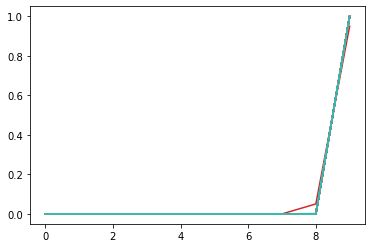

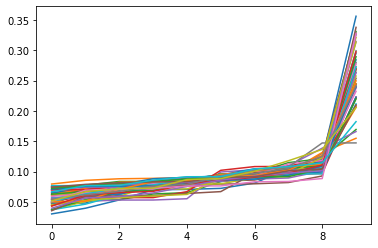

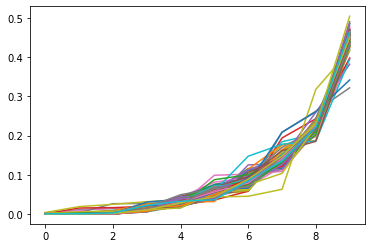

In [144]:
## Plot constrained softmax probabilities generated by the model

import matplotlib.pyplot as plt
ind = np.random.choice(len(preds['teacher_no_T']), 50)
plt.plot(np.sort(preds['teacher_no_T'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['teacher']), 50)
plt.plot(np.sort(preds['teacher'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['soft_teacher']), 500)
plt.plot(np.sort(preds['soft_teacher'])[ind].T)
plt.show()

In [110]:
from collections import Counter

pairs = [(x[-1], x[-2]) for x in np.argsort(preds['soft_teacher'])]
counts = Counter(pairs)
counts.most_common(20)

[((1, 8), 6651),
 ((7, 9), 6180),
 ((3, 5), 6073),
 ((0, 8), 5912),
 ((6, 8), 5889),
 ((2, 8), 5884),
 ((9, 8), 5848),
 ((4, 9), 5843),
 ((8, 5), 5713),
 ((5, 8), 5393),
 ((8, 9), 99),
 ((7, 2), 60),
 ((1, 7), 53),
 ((9, 4), 47),
 ((9, 7), 44),
 ((7, 1), 24),
 ((2, 7), 24),
 ((1, 4), 23),
 ((5, 3), 23),
 ((3, 2), 23)]

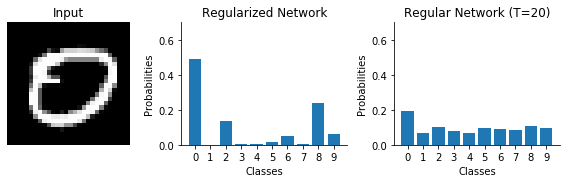

In [135]:
i = np.random.randint(len(x_train))
#i = 54270
fig, ax = plt.subplots(1, 3, figsize=(10,2.5), gridspec_kw={'width_ratios': [1.6, 2, 2], 'wspace': 0.3})
# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2)
ax[0].imshow(x_train[i][:,:,0], cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('Input')
ax[1].bar(np.linspace(0,9,10), preds['soft_teacher'][i])
ax[1].set_xticks(np.arange(0, 10, step=1))
ax[1].set_ylim(top=0.7)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Regularized Network')
ax[2].bar(np.linspace(0,9,10), preds['teacher'][i])
ax[2].set_xticks(np.arange(0, 10, step=1))
ax[2].set_ylim(top=0.7)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Probabilities')
ax[2].set_title('Regular Network (T=20)')
plt.savefig('figures/mnsit_{}.pdf'.format(i))
plt.show()

#plt.savefig('foo.png')

In [71]:
i

54270

In [ ]:
from collections import Counter

pairs = [(x[0], x[1]) for x in np.argsort(preds_st)]
counts = Counter(pairs)
counts.most_common(len(counts))

In [94]:
import tensorflow as tf
a = [[1, 10, 7, 9, 3, 66], [6, 4, 3, 2, 100, 0]]
b = tf.sort(a,axis=-1,direction='ASCENDING',name=None)
c = tf.keras.backend.eval(b)
c

array([[  1,   3,   7,   9,  10,  66],
       [  0,   2,   3,   4,   6, 100]], dtype=int32)